# Modelling

Rodrigo Becerra Carrillo

https://github.com/bcrodrigo

# Introduction

Notebook to perform Modelling (sentiment analysis) on a reviews dataset of Amazon foods.

The dataset was sourced from [here](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data).

Previously we already cleaned and balanced the dataset, and determined that only about 10% of such dataset would be a able to use for Vectorization using the bag-of-words model.

In this notebook, we'll try to baseline some models, and try to determine which one is most suited for the sentiment analysis task.

## Import Custom Modules

In [1]:
import sys
sys.path

['/Users/rodrigo/anaconda3/envs/nlp_env/lib/python311.zip',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/lib-dynload',
 '',
 '/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages']

In [2]:
sys.path.append('..')

In [3]:
from src.preprocessing import downsample_dataframe

In [4]:
from src.custom_tokenizer import tokenizer_and_lemma

## Import Libraries

In [5]:
import numpy as np
import pandas as pd

## Read Dataframe and Downsample

In [6]:
df = pd.read_csv('../data/reviews_clean_balanced.csv.gz',compression = 'gzip')

In [7]:
df.shape

(89262, 2)

In [8]:
df.head()

,Score,Text
0,0,My husband is originally from Germany and enjo...
1,0,I ordered this three times to be delivered to ...
2,0,We bought this as a low carb substitute for th...
3,0,If I could have given this product no stars I ...
4,0,I bought these chocolate frogs as part of a su...


In [9]:
# downsample to 10% of the dataframe
df_downsampled = downsample_dataframe(df,0.1)

In [10]:
df_downsampled.shape

(8925, 2)

## Train Validation and Test Split

In [11]:
from sklearn.model_selection import train_test_split

X = df_downsampled['Text']
y = df_downsampled['Score'].values

common_options = {
    'train_size':0.9,
    'random_state':10
}

X_train,X_test,y_train,y_test = train_test_split(X,y,**common_options, stratify=y)

In [14]:
X_train.shape

(8032,)

### Instantiate Bag-of-words

Notice we're instantiating the bag of words count vectorizer now, on a separate step than the rest of the processing pipeline. This is intentional, as we want to use the same parameters for the CountVectorizer in both the training and test set. Further, we'll:

- limit the document frequency to 10
- cap the max number of features to 500

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

bagofwords = CountVectorizer(tokenizer=tokenizer_and_lemma, min_df = 10, max_features = 500)

In [16]:
bagofwords.fit(X_train)

/Users/rodrigo/anaconda3/envs/nlp_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=500, min_df=10,
                tokenizer=<function tokenizer_and_lemma at 0x13b48bba0>)

In [17]:
X_train_transformed = bagofwords.transform(X_train)
X_train_transformed.shape

(8032, 500)

In [18]:
# vectorize the test data
X_test_transformed = bagofwords.transform(X_test)

# Define Processing Pipeline

Here we're just testing the processing pipeline, without optimizing any hyperparameters

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [20]:
# use a standard scaler
estimators = [('scaler',StandardScaler(with_mean = False)),
              ('logreg',LogisticRegression(random_state=10))]

# define a pipeline
pipe = Pipeline(estimators, verbose = True)

In [21]:
pipe.fit(X_train_transformed,y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg', LogisticRegression(random_state=10))],
         verbose=True)

In [22]:
train_score_pipe = pipe.score(X_train_transformed,y_train)

In [23]:
train_score_pipe

0.6795318725099602

In [24]:
#  check the test score
test_score_pipe = pipe.score(X_test_transformed,y_test)
test_score_pipe

0.5957446808510638

We see that there is a lower score for the test data, so we'll have to do some hyperparameter tunning to minimize overfitting.

## Save accuracy scores

In [25]:
from src.update_models_df import values_to_update, model_df

In [26]:
values = values_to_update()

In [27]:
values['model'] = "logistic regression"
values['train_score'] = train_score_pipe
values['test_score'] = test_score_pipe
values['num_features'] = 500
values['comments'] = 'no hyperparameter tuning'

In [28]:
model_df?

Signature: model_df(df, values_to_add)
Docstring:
To update dataframe keeping track of models. The dataframe will have the following columns:
    - model (str)
    - train_score (float)
    - test_score (float)
    - num_features (int)
    - comments (str)

Parameters
----------
df : DataFrame
    Pandas dataframe where we're appending the new values. Note, that if we don't have a dataframe yet, we only pass pd.Dataframe()

values_to_add : dictionary
    Up-to-date dictionary generated with `values_to_update()`

Returns
-------
DataFrame
    Up-to-date dataframe containing previous and newly added values.
File:      ~/Documents/Github/nlp_reviews/src/update_models_df.py
Type:      function

In [29]:
df_models = model_df(pd.DataFrame(),values)

In [30]:
df_models

,model,train_score,test_score,num_features,comments
0,logistic regression,0.679532,0.595745,500,no hyperparameter tuning


## Choose regularization parameter C for Logistic Regression

Here, we're going to check what happens when we change the regularization strength to the logistic regression model.

In [ ]:
from tempfile import mkdtemp
# cached directory to speed up calculations
cachedir = mkdtemp()


all_Cvalues  = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]
X_test_transformed = bagofwords.transform(X_test)

all_test_scores = []
all_train_scores = []

for Cvalue in all_Cvalues:    
    # same estimators as before
    estimators = [('scaler',StandardScaler(with_mean = False)),
                  ('logreg',LogisticRegression(random_state=10,C = Cvalue))
                 ]
    # pipeline
    pipe = Pipeline(estimators, verbose = True, memory = cachedir)

    pipe.fit(X_train_transformed,y_train)
    train_score_pipe = pipe.score(X_train_transformed,y_train)
    test_score_pipe = pipe.score(X_test_transformed,y_test)

    all_train_scores.append(train_score_pipe)
    all_test_scores.append(test_score_pipe)

Next, let's plot the train and test scores against C.

In [ ]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(all_Cvalues,all_train_scores,label = 'Train Score',marker = '.')
plt.plot(all_Cvalues,all_test_scores,label = 'Test Score', marker = '.')

plt.title('Accuracy Scores vs Regularization Parameter')
plt.xlabel('C value')
plt.ylabel('Accuracy Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

We see that a C value of 10^-4 gives us the highest test accuracy with a train accuracy of 0.65

# Choose Regularization Parameter with Grid Search

In [31]:
from sklearn.model_selection import GridSearchCV
from tempfile import mkdtemp

cachedir = mkdtemp()

# same estimators as before
estimators = [('scaler',StandardScaler(with_mean = False)),
              ('logreg',LogisticRegression(random_state=10))
             ]

# pipeline
pipe = Pipeline(estimators, verbose = True, memory = cachedir)

In [32]:
params = {'logreg__C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100]
         }

grid_search = GridSearchCV(pipe, param_grid = params, cv = 5)

In [33]:
fitted_search = grid_search.fit(X_train_transformed,y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.0s
[Pipel

These are the best parameters according to the grid search

In [34]:
grid_search.best_params_

{'logreg__C': 0.0001}

In [35]:
grid_search.best_score_

0.6146659113576112

In [36]:
grid_search.best_estimator_

Pipeline(memory='/var/folders/f8/657w0x_93w9f5ryhcd7rk3gm0000gn/T/tmpx4mh71q5',
         steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg', LogisticRegression(C=0.0001, random_state=10))],
         verbose=True)

# Re-train Base model (Logistic) with C = 0.0001

We'll now re-train the model using the value of C we found with cross validation

In [37]:
best_estimator = [('scaler',StandardScaler(with_mean = False)),
              ('logreg',LogisticRegression(random_state=10, C=0.0001))
             ]

best_pipe = Pipeline(best_estimator, verbose = True)

In [38]:
# Train with best hyperparameters
best_pipe.fit(X_train_transformed,y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing logreg, total=   0.1s


Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg', LogisticRegression(C=0.0001, random_state=10))],
         verbose=True)

In [39]:
train_score_pipe = best_pipe.score(X_train_transformed,y_train)
test_score_pipe = best_pipe.score(X_test_transformed,y_test)

In [40]:
train_score_pipe

0.6480328685258964

In [41]:
test_score_pipe

0.6159014557670772

## Save Accuracy Scores - Model 1 

In [43]:
values = values_to_update()

values['model'] = "logistic regression"
values['train_score'] = train_score_pipe
values['test_score'] = test_score_pipe
values['num_features'] = 500
values['comments'] = 'C = 0.0001'

In [44]:
df_models = model_df(df_models,values)
df_models

,model,train_score,test_score,num_features,comments
0,logistic regression,0.679532,0.595745,500,no hyperparameter tuning
1,logistic regression,0.648033,0.615901,500,C = 0.0001


# Model Evaluation

We're going to use the Confusion Matrix to evaluate the performance of the model

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [46]:
y_pred = best_pipe.predict(X_test_transformed)

## Confusion Matrix

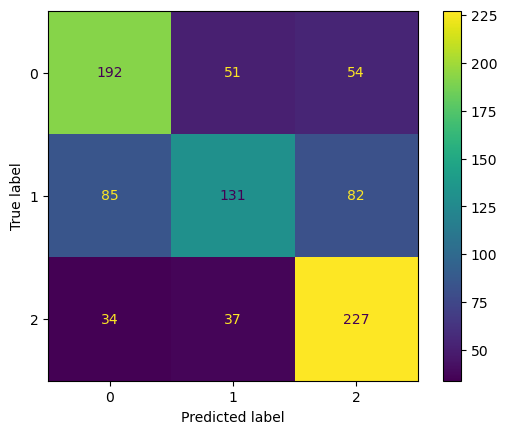

In [48]:
cf_mat_base = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(cf_mat_base).plot()

In [49]:
from sklearn.metrics import classification_report

In [50]:
report = classification_report(y_test,y_pred,digits = 4)
print(report)

              precision    recall  f1-score   support

           0     0.6174    0.6465    0.6316       297
           1     0.5982    0.4396    0.5068       298
           2     0.6253    0.7617    0.6868       298

    accuracy                         0.6159       893
   macro avg     0.6136    0.6159    0.6084       893
weighted avg     0.6136    0.6159    0.6084       893



We can see that the F1 score for negative and positive reviews is higher than that of neutral. This means the model is having more difficulty classifying the neutral reviews correctly. We can see this from the confusion matrix, where true label 1 is incorrectly predicted as 0 or 2.

# Further Actions

- Since the accuracy score is low, we'll need to choose a more complex model, perhaps random-forest based, or ensemble based.
- Other models to try are TFID, and neural network based models.